---

title: Linux PWM 的使用

keywords: maixpy3, PWM, Linux

desc: maixpy3  PWM 的使用

---

| 更新时间 | 负责人 | 内容 | 备注 |
| --- | --- | --- | --- |
| 2022年1月4日 | Rui | 初次编写文档 | --- |
| 2022年1月8日 | Rui | 修改文档的编写方式 | 使用 Jupyter notebook 进行编写文档 |
| 2022年1月18日 | Rui | 修改文档，增加效果图 | 外设文档通过测试的平台有 MaixII-Dock,使用的是 MaixPy3 0.4.0 |
| 2023年5月5日 | lyx | 接收文档并整合 | PWM 深入理解与调试 |

MaixPy3 把 Linux 系统中的 PWM 的使用方法进行封装和简化使用，让用户使用起来更加的简单。

## 使用方式

PWM 的使用方式和 GPIO 的类似，需要根据管脚定义图确定所使用的 PWM 通道序号，下面以 MaixII-Dock 为例子讲述如何使用 MaixPy3 中的 PWM 

### 准备

查看开发板的管脚定义图选择 PWM 输出通道序号，PWM-x 是指 PWM 的输出通道序号。

<img src="./../asserts/M2Dock_pin.jpg" width=450px>
<img src="./../asserts/R329-pin.jpg" height=450px>

这里选择使用 PWM-8，假设硬件都有这个资源如果没有就根据实际情况修改一下。

### 开始

先将 PWM-8 实例化设置周期和占空比，最后是使能 PWM 就可以输出了，具体代码看下面。

In [1]:
from maix import pwm
import time
test_pwm = pwm.PWM(8)
test_pwm.export()
test_pwm.period = 20000000  # 表示 pwm 的周期，单位 ns
test_pwm.duty_cycle = 500000  # 表示占空比，单位 ns
test_pwm.enable = True        # 表示是否使能 pwm
for t in range (3):
    for i in range(500000, 15000000, +100000):
        test_pwm.duty_cycle = i
        time.sleep(0.05)
    for i in range(15000000, 500000, -100000):
        test_pwm.duty_cycle = i
        time.sleep(0.05)

[ rpyc-kernel ]( running at Mon Jan 17 16:58:42 2022 )



Traceback (most recent call last):
  File "<string>", line unknown, in <module>
Remote.KeyboardInterrupt


别的开发板使用方式是同样的流程（包括树莓派）

> 注明：
> 建议小白使用在对应开发管脚定义图上的对应 PWM 通道，别的通道需要自行查看 [Linux PWM](https://www.baidu.com/s?ie=UTF-8&wd=Linux%20PWM) 使用方法。


## PWM 用途

1. 呼吸灯
    
    ![PWM](./../asserts/pwm.gif)
2. PWM 可以作为电机驱动控制信号，驱动舵机。但是外接电机的时候需要做好电源隔离，不要直接将舵机接到开发板上，舵机产生的反向电流会把开发板上的芯片给击穿。

    ![PWM_1](./../asserts/PWM_1.gif)

## PWM 深入理解与调试（M2dock）

> 内容根据全志 V831 数据手册而来，具体寄存器配置请参考 [全志 V831 数据手册](https://linux-sunxi.org/images/b/b9/V833%EF%BC%8FV831_Datasheet_V1.0.pdf)

### V831 PWM 介绍

首先查阅全志 V831 数据手册的第十一章，可以得到其 PWM 具有以下几个特性：

* 10个 PWM 通道(5个 PWM 对)支持脉冲(可配置脉冲数) 
* 周期和互补对输出支持捕获输入编程死区输出内置可编程死区发生器
* 可控死区输出
* 三种输出波形: 连续波形，脉冲波形和互补对
* 输出频率范围: 0 ~ 24MHz/100MHz 
* 输出占空比: 0% ~ 100% 
* 最小分辨率: 1/65536
* 中断产生的 PWM 输出和捕获输入
* PWM 启动和停止是可控的!

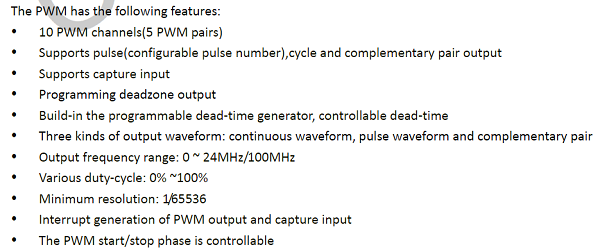

> 这里只说明连续模式下的配置流程，其他模式请查看数据手册。

### 工作流程

> 这里列出 PWM0 的配置方法，其他的 PWM 同理可用。

- **时钟**

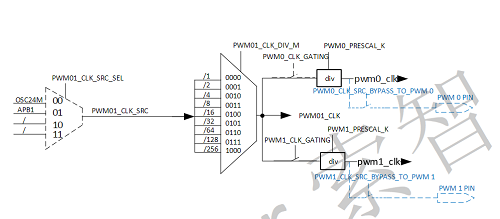

由上图可知，需要首先配置 PWM01_CLK_SRC_SEL 来选择时钟源，其次根据 PWM01_CLK_DIV_M 来选择时钟源的分频，打开 PWM0_CLK_GATING 后再配置 PWM_PRESCAL_K 分频，由此我们可以得到 pwm0_clk 的时钟。

- **PWM 输出**

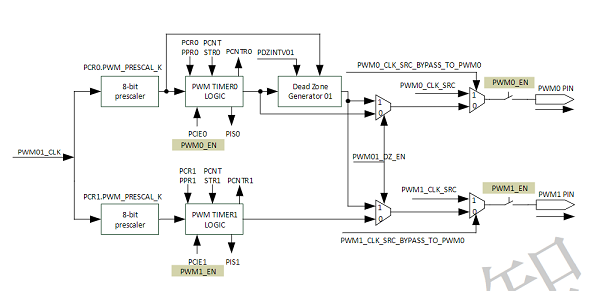

根据数据手册了解 PWM 模块逻辑模块（PWM _ TIMER _ LOGIC）由一个 **16 位上行计数器（PCNTR）**和**三个 16 位参数（PWM _ ENTIRE _ CYCLE、 PWM _ AIVE _ CYCLE 和 PWM _ CNTSTART）**组成。

**PWM _ ENTIRE _ CYCLE 用于 PWM 周期控制，PWM _ AIVE _ CYCLE 用于占空比控制**，PWM _ CNTSTART 用于相位输出控制(多通道同步工作要求)。PWM _ ENTIRE _ CYCLE 和 PWM _ AIVE _ CYCLE 支持缓存加载，**在 PWM 输出启用后，PWM _ ENTIRE _ CYCLE 和 PWM _ AIVE _ CYCLE 的寄存器值可以随时更改**，更改后的值缓存到缓存寄存器中。当 PCNTR 计数输出一个周期的 PWM 波形时，可以更新缓存寄存器的值以实现 PCNTR 控制。在更新 PWM _ ENTIRE _ CYCLE 和 PWM _ AIVE _ CYCLE 时，缓存加载可以很好地避免 PWM 输出波形不稳定带有毛刺特征。CNTSTART 支持缓存加载，只能在 PWM 输出启用之前配置。PWM 支持周期和脉冲波形输出。

**周期模式**: PWM 反复输出设定波形（即一个连续的方波）；**脉冲模式**: 在预设 PWM _ PULNUM _ CNT 后 PWM 输出（PWM _ PULNUM + 1）周期的 PWM 波形，即多个脉冲的波形。

### 配置流程

- **时钟源**

**根据书册手册可知，配置流程如图：**

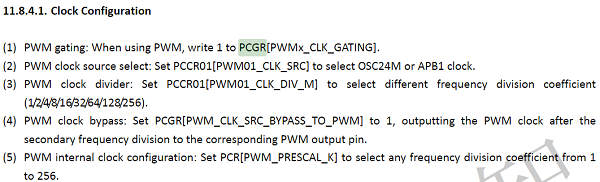

1. 配置 PCGR 寄存器，开启时钟。
2. 配置 PCCR01 关于时钟源选择相关位，去选择时钟源。
3. 配置 PCCR01 关于时钟分频的位，选择分频。
4. 将 PCGR [PWM _ CLK _ SRC _ BYPASS _ TO _ PWM] 设置为 1，将二次频率分割后的 PWM 时钟输出到相应的 PWM 输出端。
5. 设置 PCR [PWM _ PRESCAL _ K] 来选择从 1 到 256 的任何频分系数。

- **PWM 配置**

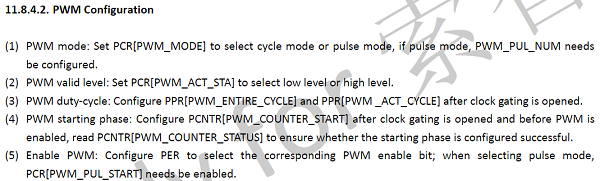

**由数据手册可以知道，大致流程如下：**

1. PWM 模式: 设置 PCR [PWM _ MODE] 选择循环模式或脉冲模式，如果脉冲模式，则需要配置 PWM _ PUL _ NUM。
2. PWM 有效电平: 设定 PCR [PWM _ ACT _ STA] 选择低电平或高电平。
3. PWM 占空比: 开时钟门后配置 PPR [PWM _ ENTIRE _ CYCLE] 和 PPR [PWM _ ACT _ CYCLE]。
4. PWM 启动阶段: 在开启时钟门之后和开启 PWM 之前配置 PCNTR [PWM _ COUNTER _ START] ，读取 PCNTR [PWM _ COUNTER _ STATUS] 以确保启动阶段是否配置成功。
5. 启用 PWM: 将 PER 配置为选择相应的 PWM 启用位，在选择脉冲模式时需启用 PCR [PWM _ PUL _ START]。

### 寄存器列表

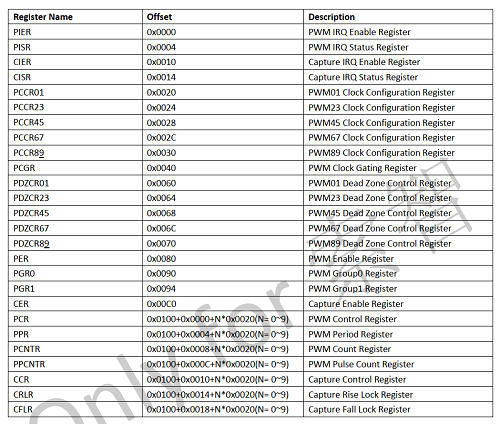

> 更加详细的寄存配置请参考文章标题下的V831数据手册第11章节。

### 例程

> 这里以 pwm6 与 pwm7 为例，需要增加 pwm8 同理。

In [ ]:
class PWM:
    #读取寄存器的值
    def pwm_reg_get(self,reg_add): 
        reg_value = None
        reg_addr  = None                                                    
        with open("/sys/class/sunxi_dump/dump","wb") as f:    
            reg_addr = bytes(hex(reg_add), 'ascii')           
            f.write(reg_addr)                                 
        with open("/sys/class/sunxi_dump/dump","rb") as f:                  
            reg_value = f.read()                                            
            reg_value = reg_value[:-1]                                      
        out_add = 'Reg  addr : ' + hex(reg_add)                             
        out_val = 'Read value: ' + bytes.decode(reg_value, encoding='ascii')
        print(out_add + ", " + out_val)
    #向寄存器写值
    def pwm_reg_set(self,reg_add, reg_val):
        with open("/sys/class/sunxi_dump/write","wb") as f:                 
            reg_set = hex(reg_add) + ' ' + hex(reg_val)
            reg_set = bytes(reg_set, 'ascii')
            f.write(reg_set)
    def __init__(self, num):
        from maix import pwm
        self.pwm = pwm.PWM(num)
        self.pwm.export()
        self.pwm.period = 20000000  # 表示 pwm 的周期，单位 ns
        self.pwm.duty_cycle = 500000  # 表示占空比，单位 ns
        self.pwm.enable = True       # 表示是否使能 pwm

        self.pwm_reg_set(0x0300A1C0, 0x00000107)              # PCR6 设置PWM有效时候电平为1，8分频
        self.pwm_reg_set(0x0300A1E0, 0x00000107)              # PCR7 设置PWM有效时候电平为1，8分频
        self.pwm_reg_set(0x0300A1C4, (60000 << 16) + (30000)) # PPR6 设置频率为60000个周期，占空比为30000个周期
        self.pwm_reg_set(0x0300A1E4, (60000 << 16) + (30000)) # PPR7 设置频率为60000个周期，占空比为30000个周期
        self.pwm_reg_set(0x0300A1C8, 0x00000000)              # PCNTR6  计数器初始化为
        self.pwm_reg_set(0x0300A1E8, 0x00000000)              # PCNTR7  计数器初始化为0

        self.pwm_reg_get(0x0300A040) # 获取PCGR=0x000000c0    pwm67的时钟源已打开                                          
        self.pwm_reg_get(0x0300A02C) # 获取PCCR67=0x00000000  配置为24MHZ时钟，不分频                                       
        self.pwm_reg_get(0x0300A080) # 获取PER=0x000000c0     使能pwm6,7                                         

        self.pwm_reg_get(0x0300A1C0) # 获取PCR6=0x00000107 PWM有效时候电平为1，8分频                              
        self.pwm_reg_get(0x0300A1E0) # 获取PCR7=0x00000107 PWM有效时候电平为1，8分频                              
                                                                                
        self.pwm_reg_get(0x0300A1C4) # 获取PPR6 配置脉宽占空比                             
        self.pwm_reg_get(0x0300A1E4) # 获取PPR7 配置脉宽占空比                             
                                                                                
        self.pwm_reg_get(0x0300A1C8) # PCNTR6                            
        self.pwm_reg_get(0x0300A1E8) # PCNTR7
        print('new')
    def duty_cycle(self, duty_cycle):
        self.pwm.duty_cycle = duty_cycle
    def unexport(self):
        self.pwm.unexport()
        print('del')

import time
pwm6 = PWM(6)
pwm7 = PWM(7)

for t in range (3):
    for i in range(500000, 15000000, +100000):
        pwm6.duty_cycle(i)
        time.sleep(0.05)
    for i in range(15000000, 500000, -100000):
        pwm6.duty_cycle(i)
        time.sleep(0.05)
        
pwm6.unexport()                                     
pwm7.unexport()

## 了解更多

更多关于 Linux PWM 的可以查看[大佬鼠](https://www.cnblogs.com/juwan/p/14343977.html)的博客。